# Cutting-Stock model: column generation with Python/Gurobi

## [Jon Lee](https://sites.google.com/site/jonleewebpage/home), 10/20/2020

\begin{align*}
\min~ &\mathbf{e}'x\\
&Ax-t=d\\
&x,t\geq 0,
\end{align*}
where the columns of $A$ are cutting patterns, and $d$ is the demand vector.

Notes:
* In this implementaion, we never delete generated columns (i.e., patterns)
* Knapsack subproblems solved by DP or ILP (Gurobi) or both [user options]
* At the end, we solve the ILP over all columns generated, aiming to improve on the rounded-up LP solution from column-generation 

References:
* Jon Lee, "A First Course in Linear Optimization", Fourth Edition (Version 4.0), Reex Press, 2013-20.

MIT License

Copyright (c) 2020 Jon Lee

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%reset -f
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid"); color_list = sns.color_palette("muted") 
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
# set at least one of the following two parameters to 'True'
# if both are set to 'True', then DP overwrites what IP calculates (but we can still compare)
IP=True # set True for solution of knapsack problem by IP (i.e., Gurobi)
DP=True # set True for solution of knapsack problem by DP
results1=[]  
results2=[] 
ITER=0

In [3]:
# Some toy data
W=110
m=5; M=range(m)
Widths=np.array([70.0,40.0,55.0,25.0,35.0])
Demands=np.array([205,2321,143,1089,117])

In [4]:
# set up the Main LP model
LP = gp.Model()
LP.setParam('OutputFlag', 0)  #comment out to see more Gurobi output
minsum = LP.setObjective(0, GRB.MINIMIZE)
s=LP.addVars(m)
for i in M:
    LP.addConstr(-s[i] == Demands[i])
LP.update()
demandconstraints=LP.getConstrs()
# initialize with elementary patterns
nPAT=0
A = np.zeros((m,m))
for i in M:
    nPAT += 1
    A[i,nPAT-1] = np.floor(W/Widths[i])   
    newcol=gp.Column(A[:,i],demandconstraints)
    LP.addVar(obj=1.0, column=newcol)
LP.update()

Academic license - for non-commercial use only - expires 2021-08-26
Using license file C:\Users\jonxlee\gurobi.lic


# The Knapsack model for generating an improving column
\begin{align*}
\max~ &\sum_{i=1}^m \bar{y}_i a_i\\
&\sum_{i=1}^m w_i a_i \leq W\\
&a_i \geq 0 \mbox{ and integer, for } i=1,\ldots m.
\end{align*}

In [5]:
# set up for solving the knapsack subproblems: either by DP or IP (or both)
#
y=np.zeros(m)
if IP==True:
    # set up the Subproblem ILP knapsack model for Gurobi
    Knap = gp.Model()
    Knap.setParam('OutputFlag', 0)  #comment out to see more Gurobi output
    a = Knap.addMVar(m,vtype=GRB.INTEGER)
    knapsackobjective = Knap.setObjective(y@a, GRB.MAXIMIZE)
    knapsackconstraint = Knap.addConstr(Widths@a <= W)
if DP==True:
    # DP for knapsack. Local notation: max c'x, s.t. a'x <= b, x>=0 int.
    def Knapf(a,b,c):
        m=np.size(a)
        f=np.zeros(b+1)
        i=-np.ones(b+1,dtype=int)
        v=-np.Inf*np.ones(m)
        for s in range(min(a),b+1): 
            for j in range(m):
                if a[j]<=s: v[j]=c[j] + f[s-a[j]]
                else: v[j]=-np.Inf 
            f[s]=max(v)
            i[s]=np.argmax(v)   # save the index j where the max occured for that s
        #
        x=np.zeros(m)
        s=b+0
        while s>=min(a):
            x[i[s]] += 1
            s=s-a[i[s]]
        return f[b], x

In [6]:
# fancy output function 
def fancyoutput():  
    plt.figure()
    print("***** Patterns / Widths:", Widths, "Stock roll width:", W)
    Aw=np.zeros((m,nPAT))
    for i in M:
        for j in range(nPAT):
            Aw[i,j]=A[i,j]*Widths[i]
    Aw=np.c_[ Aw, np.zeros(m) ]    
    wlist=[''] * m
    for i in M:
        wlist[i]='w'+str(i)
    K=np.diagflat(Widths)
    Bw=np.c_[Aw,K]
    T = np.arange(Bw.shape[1])
    for i in range(Bw.shape[0]):
        plt.bar(T, Bw[i],
        tick_label = np.concatenate((np.arange(nPAT),np.array([' ']),wlist)),
        bottom = np.sum(Bw[:i], axis = 0),
        color = color_list[i % len(color_list)])
    plt.show()

    print("***** A:")
    print(A)

 
***** Solving LP...
***** A:
[[1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 4. 0.]
 [0. 0. 0. 0. 3.]]
***** x:
x[ 0 ]= 205.0
x[ 1 ]= 1160.5
x[ 2 ]= 71.5
x[ 3 ]= 272.25
x[ 4 ]= 39.0
***** y': [1.     0.5    0.5    0.25   0.3333]
 
***** Solving Knapsack...
***** Gurobi Knap objval: 1.5
***** DP Knap objval:     1.5
***** Column: [1. 1. 0. 0. 0.]
 
***** Solving LP...
***** A:
[[1. 0. 0. 0. 0. 1.]
 [0. 2. 0. 0. 0. 1.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0.]
 [0. 0. 0. 0. 3. 0.]]
***** x:
x[ 0 ]= 0.0
x[ 1 ]= 1058.0
x[ 2 ]= 71.5
x[ 3 ]= 272.25
x[ 4 ]= 39.0
x[ 5 ]= 205.0
***** y': [0.5    0.5    0.5    0.25   0.3333]
 
***** Solving Knapsack...
***** Gurobi Knap objval: 1.25
***** DP Knap objval:     1.25
***** Column: [0. 2. 0. 1. 0.]
 
***** Solving LP...
***** A:
[[1. 0. 0. 0. 0. 1. 0.]
 [0. 2. 0. 0. 0. 1. 2.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 1.]
 [0. 0. 0. 0. 3. 0. 0.]]
***** x:
x[ 0 ]= 0.0
x[ 1 ]= 0.0
x[ 2 ]= 71.5
x[ 3 ]= 7.75
x[ 4 ]= 39.0
x[ 5 ]= 205.0

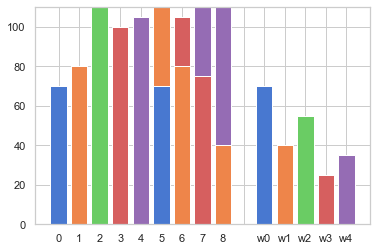

***** A:
[[1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 2. 0. 1.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 1. 3. 0.]
 [0. 0. 0. 0. 3. 0. 0. 1. 2.]]


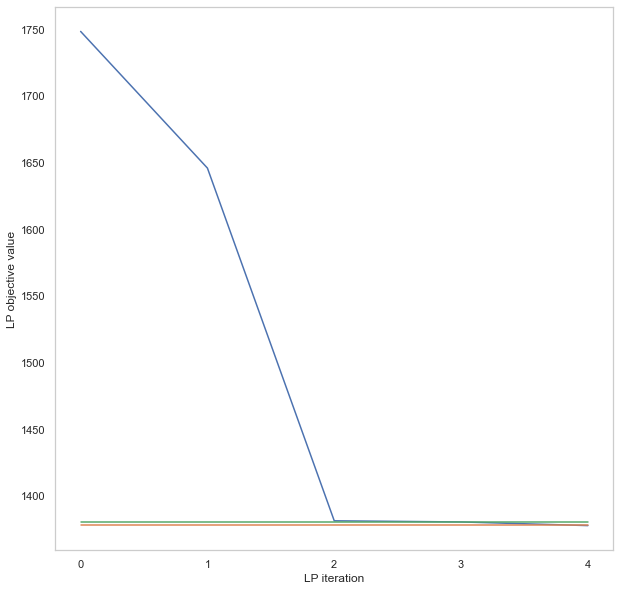

LP iter     LP val
---------  ---------
0           1748.25
1           1645.75
2           1381.25
3           1380.3889
4           1377.6538
 


In [7]:
while True:
    print(" ")
    print("***** Solving LP...")
    ITER += 1
    LP.optimize()
    if LP.status != GRB.Status.OPTIMAL:
        print("***** Gurobi solve status:", LP.status)
        print("***** This is a problem. LP does not have an optimal solution")
        raise StopExecution
    results1=np.append(results1,ITER-1)
    results2=np.append(results2,LP.Objval)
    print("***** A:")
    print(A)
    print("***** x:")
    x = LP.getVars()
    for j in range(nPAT):
         print("x[",j,"]=",round(x[j+m].X,4))
    for i in M:
        y[i]=demandconstraints[i].Pi
    print("***** y':",np.round(y,4))
    #
    if IP==True:
        knapsackobjective = Knap.setObjective(y@a, GRB.MAXIMIZE)
        print(" ")
        print("***** Solving Knapsack...")
        Knap.optimize()
        if Knap.status != GRB.Status.OPTIMAL:
            print("***** Gurobi solve status:", Knap.status)
            print("***** This is a problem. Knapsack IP does not have an optimal solution")
            raise StopExecution
        print("***** Gurobi Knap objval:",Knap.Objval)
        reducedcost = 1.0-Knap.Objval
        pattern=a.X+np.zeros(m)
    #
    if DP==True: 
        results = Knapf(Widths.astype(int),W,y)
        print("***** DP Knap objval:    ",results[0])
        reducedcost = 1.0-results[0]
        pattern=results[1]
    #
    if reducedcost < -0.0001:
        print("***** Column:",pattern)
        A=np.c_[ A, pattern ]      
        nPAT += 1
        newcol=gp.Column(pattern,demandconstraints)
        LP.addVar(obj=1.0, column=newcol)
    else:
        print("***** No more improving columns")
        break
    
print("***** Pattern generation complete. Main LP solved to optimality.")
print("***** Total number of patterns generated: ", nPAT)
print("***** A:")
print(A)
print("***** x:")
x = LP.getVars()
for j in range(nPAT):
    print("x[",j,"]=",round(x[j+m].X,4))
print("***** Optimal LP objective value:", LP.Objval)
print("***** rounds up to: ", np.ceil(LP.Objval), "(lower bound on rolls needed)")
print("***** x rounded up:")
for j in range(nPAT):
    print("x[",j,"]=",np.ceil(x[j+m].X))
print("***** Number of rolls used:", sum(np.ceil(x[j+m].X) for j in range(nPAT)))
fancyoutput()
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(results1[0:ITER], results2[0:ITER])
ax.plot(results1, np.ceil(LP.Objval)*np.ones(ITER))
ax.plot(results1, sum(np.ceil(x[j+m].X) for j in range(nPAT))*np.ones(ITER))
ax.set(xlabel='LP iteration', ylabel='LP objective value')
ax.set_xticks(ticks=results1, minor=False)
ax.grid()
plt.show()
print("LP iter", "    LP val")
print("---------  ---------")
for j in range(ITER):
    print(np.int(results1[j]), "         ", np.round(results2[j],4))
print(" ")

 
***** Now solve the ILP over all patterns generated to try and get a better soution...
***** x:
x[ 0 ]= 0.0
x[ 1 ]= 0.0
x[ 2 ]= 72.0
x[ 3 ]= 1.0
x[ 4 ]= 1.0
x[ 5 ]= 205.0
x[ 6 ]= 1034.0
x[ 7 ]= 17.0
x[ 8 ]= 49.0
***** Number of rolls used: 1379.0
***** Patterns / Widths: [70. 40. 55. 25. 35.] Stock roll width: 110


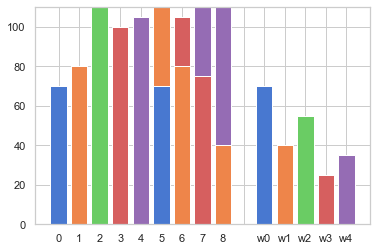

***** A:
[[1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 2. 0. 1.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 1. 3. 0.]
 [0. 0. 0. 0. 3. 0. 0. 1. 2.]]


In [8]:
print(" ")
print("***** Now solve the ILP over all patterns generated to try and get a better soution...")
for var in LP.getVars():
    var.vtype=GRB.INTEGER
LP.optimize()
if LP.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", LP.status)
    print("***** This is a problem. Hit enter to continue")
    input()
print("***** x:")
for j in range(nPAT):
    print("x[",j,"]=",round(x[j+m].X+0,4))
print("***** Number of rolls used:", sum(np.ceil(x[j+m].X) for j in range(nPAT)))
fancyoutput()